In [2]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
import shutil
#import ftransc

In [29]:
typeimg='mel_spectrogram'
train_directory = './data/mel_spectrogram/train_oneclass/hungry_one'
test_directory = './data/mel_spectrogram/test_oneclass/hungry_one'


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=None, subset=None)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 303 files belonging to 2 classes.
Found 154 files belonging to 2 classes.
['hungry', 'non_hungry']


In [30]:
## create model

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint

In [32]:
x_train=[]
y_train=[]
for images, labels in train_ds.unbatch().take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

In [33]:
x_test=[]
y_test=[]
for images, labels in test_ds.unbatch().take(-1):
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

In [34]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [35]:
num_classes = 2
img_height = 256
img_width = 256
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight

In [36]:
class_weights = {0:0, 1:0}
class_count = np.array([254,49])
for i in range(num_classes):
    class_weights[i]=create_weight(303,num_classes,class_count[i])

In [41]:
model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),            
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

In [43]:
learning_rate =  0.002
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)

In [44]:
# Set the epocks
# ทำ stop + validation
epochs = 20
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,class_weight = class_weights)

#history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3)

Epoch 1/20
7/7 [==============================] - 76s 11s/step - loss: 0.7718 - accuracy: 0.4528 - val_loss: 0.6944 - val_accuracy: 0.1648
Epoch 2/20
7/7 [==============================] - 78s 11s/step - loss: 0.6906 - accuracy: 0.2547 - val_loss: 0.6942 - val_accuracy: 0.1978
Epoch 3/20
7/7 [==============================] - 77s 11s/step - loss: 0.6907 - accuracy: 0.7028 - val_loss: 0.6890 - val_accuracy: 0.8352
Epoch 4/20
7/7 [==============================] - 77s 11s/step - loss: 0.6878 - accuracy: 0.6085 - val_loss: 0.6892 - val_accuracy: 0.5055
Epoch 5/20


In [ ]:
def binary_transform(pred):
    if pred > 0.5:
        predicted = 1
    else:
        predicted = 0
    return predicted

In [ ]:
pred = model.predict(x_test)

vfunc = np.vectorize(binary_transform)
y_pred = vfunc(pred)
actual = x_test

<function matplotlib.pyplot.show(*args, **kw)>

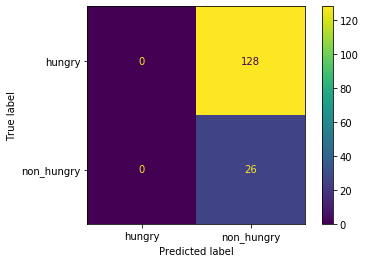

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show